In [ ]:
!pip install keras.utils

In [57]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
from glob import glob
from PIL import Image
from sklearn.model_selection import train_test_split

import keras.utils
import tensorflow as tf
from tensorflow.keras import models, layers, optimizers, losses, metrics
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [ ]:
!unzip '/content/drive/MyDrive/CVision/HAM10000.zip'

# Reading Data

In [4]:
# Directories containing the image files
directory1 = '/content/ham10000_images_part_1'
directory2 = '/content/ham10000_images_part_2'

# Function to create the dictionary
def merge_image_directories(directory1, directory2):
    image_dict = {}

    # Iterate over files in the first directory
    for filename in os.listdir(directory1):
        if filename.endswith('.jpg'):
            image_id = os.path.splitext(filename)[0]  # Remove the extension
            image_dict[image_id] = os.path.join(directory1, filename)

    # Iterate over files in the second directory
    for filename in os.listdir(directory2):
        if filename.endswith('.jpg'):
            image_id = os.path.splitext(filename)[0]  # Remove the extension
            image_dict[image_id] = os.path.join(directory2, filename)

    return image_dict

# Create the dictionary
imageid_path_dict = merge_image_directories(directory1, directory2)

lesion_type_dict = {
    'nv': 'Melanocytic nevi',
    'mel': 'Melanoma',
    'bkl': 'Benign keratosis-like lesions ',
    'bcc': 'Basal cell carcinoma',
    'akiec': 'Actinic keratoses',
    'vasc': 'Vascular lesions',
    'df': 'Dermatofibroma'
}

In [5]:
skin_df = pd.read_csv('/content/HAM10000_metadata.csv')
skin_df.head()

,lesion_id,image_id,dx,dx_type,age,sex,localization
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear


In [6]:
skin_df.shape

(10015, 7)

In [8]:
# Creating New Columns for better readability

skin_df['path'] = skin_df['image_id'].map(imageid_path_dict.get)
skin_df['cell_type'] = skin_df['dx'].map(lesion_type_dict.get)
skin_df['cell_type_idx'] = pd.Categorical(skin_df['cell_type']).codes

In [9]:
skin_df.head()

,lesion_id,image_id,dx,dx_type,age,sex,localization,path,cell_type,cell_type_idx
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp,/content/ham10000_images_part_1/ISIC_0027419.jpg,Benign keratosis-like lesions,2
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp,/content/ham10000_images_part_1/ISIC_0025030.jpg,Benign keratosis-like lesions,2
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp,/content/ham10000_images_part_1/ISIC_0026769.jpg,Benign keratosis-like lesions,2
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp,/content/ham10000_images_part_1/ISIC_0025661.jpg,Benign keratosis-like lesions,2
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear,/content/ham10000_images_part_2/ISIC_0031633.jpg,Benign keratosis-like lesions,2


# Data Cleaning

In [10]:
skin_df.isnull().sum()

lesion_id         0
image_id          0
dx                0
dx_type           0
age              57
sex               0
localization      0
path              0
cell_type         0
cell_type_idx     0
dtype: int64

In [11]:
skin_df['age'].fillna((skin_df['age'].mean()), inplace = True)

In [12]:
skin_df.isnull().sum()

lesion_id        0
image_id         0
dx               0
dx_type          0
age              0
sex              0
localization     0
path             0
cell_type        0
cell_type_idx    0
dtype: int64

In [13]:
skin_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10015 entries, 0 to 10014
Data columns (total 10 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   lesion_id      10015 non-null  object 
 1   image_id       10015 non-null  object 
 2   dx             10015 non-null  object 
 3   dx_type        10015 non-null  object 
 4   age            10015 non-null  float64
 5   sex            10015 non-null  object 
 6   localization   10015 non-null  object 
 7   path           10015 non-null  object 
 8   cell_type      10015 non-null  object 
 9   cell_type_idx  10015 non-null  int8   
dtypes: float64(1), int8(1), object(8)
memory usage: 714.1+ KB


# EDA

In [14]:
skin_df['cell_type'].value_counts()

cell_type
Melanocytic nevi                  6705
Melanoma                          1113
Benign keratosis-like lesions     1099
Basal cell carcinoma               514
Actinic keratoses                  327
Vascular lesions                   142
Dermatofibroma                     115
Name: count, dtype: int64

In [15]:
# reducing example of 'Melanocytic nevi' class to balance the data

# Filter rows with 'cell_type' equal to 'Melanocytic nevi'
melanocytic_nevi_df = skin_df[skin_df['cell_type'] == 'Melanocytic nevi']

# Randomly sample 1400 rows
if len(melanocytic_nevi_df) > 1400:
    melanocytic_nevi_indices_to_keep = melanocytic_nevi_df.sample(n=1400, random_state=42).index
    skin_df = skin_df.drop(melanocytic_nevi_df.index.difference(melanocytic_nevi_indices_to_keep))

In [16]:
skin_df.cell_type.value_counts()

cell_type
Melanocytic nevi                  1400
Melanoma                          1113
Benign keratosis-like lesions     1099
Basal cell carcinoma               514
Actinic keratoses                  327
Vascular lesions                   142
Dermatofibroma                     115
Name: count, dtype: int64

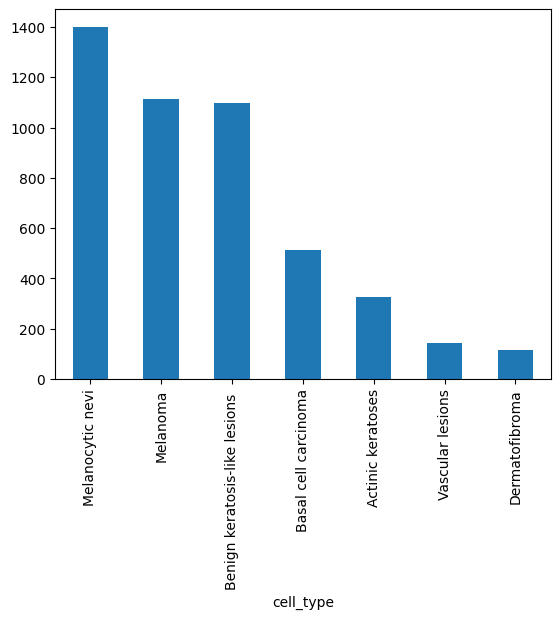

In [17]:
skin_df.cell_type.value_counts().plot(kind='bar');

<Axes: xlabel='dx_type'>

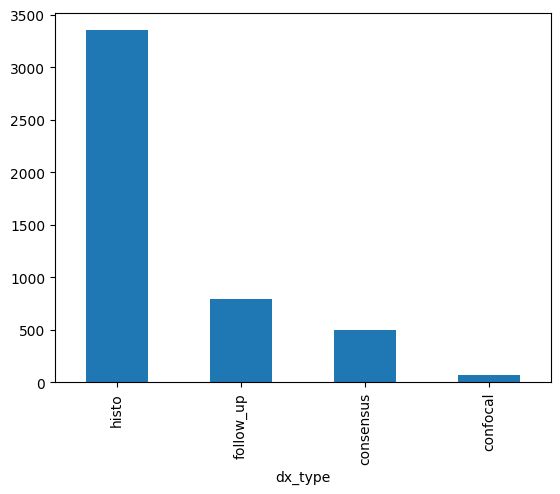

In [18]:
skin_df['dx_type'].value_counts().plot(kind='bar')

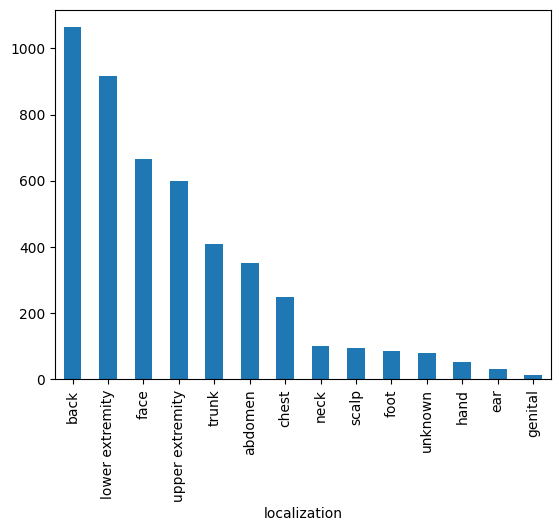

In [19]:
skin_df['localization'].value_counts().plot(kind='bar');

It seems back , lower extremity,trunk and upper extremity are heavily compromised regions of skin cancer

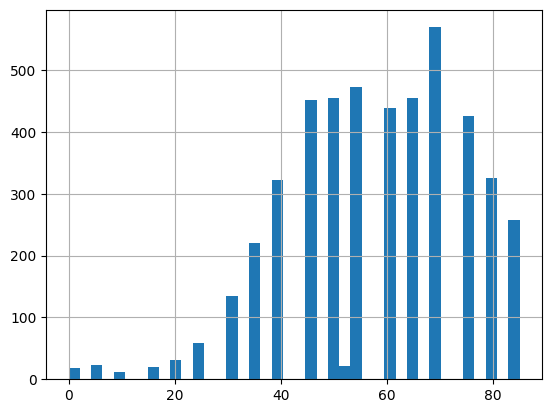

In [20]:
skin_df['age'].hist(bins=40);

<Axes: xlabel='sex'>

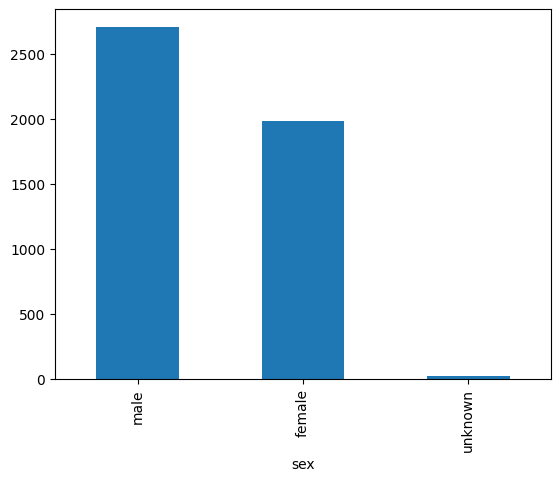

In [21]:
skin_df['sex'].value_counts().plot(kind='bar')

# Loading Images

In [22]:
skin_df['image'] = skin_df['path'].map(lambda x: np.asarray(Image.open(x).resize((100,75))))

In [23]:
skin_df.head(3)

,lesion_id,image_id,dx,dx_type,age,sex,localization,path,cell_type,cell_type_idx,image
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp,/content/ham10000_images_part_1/ISIC_0027419.jpg,Benign keratosis-like lesions,2,"[[[190, 153, 194], [192, 154, 196], [191, 153,..."
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp,/content/ham10000_images_part_1/ISIC_0025030.jpg,Benign keratosis-like lesions,2,"[[[23, 13, 22], [24, 14, 24], [25, 14, 28], [3..."
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp,/content/ham10000_images_part_1/ISIC_0026769.jpg,Benign keratosis-like lesions,2,"[[[185, 127, 137], [189, 133, 147], [194, 136,..."


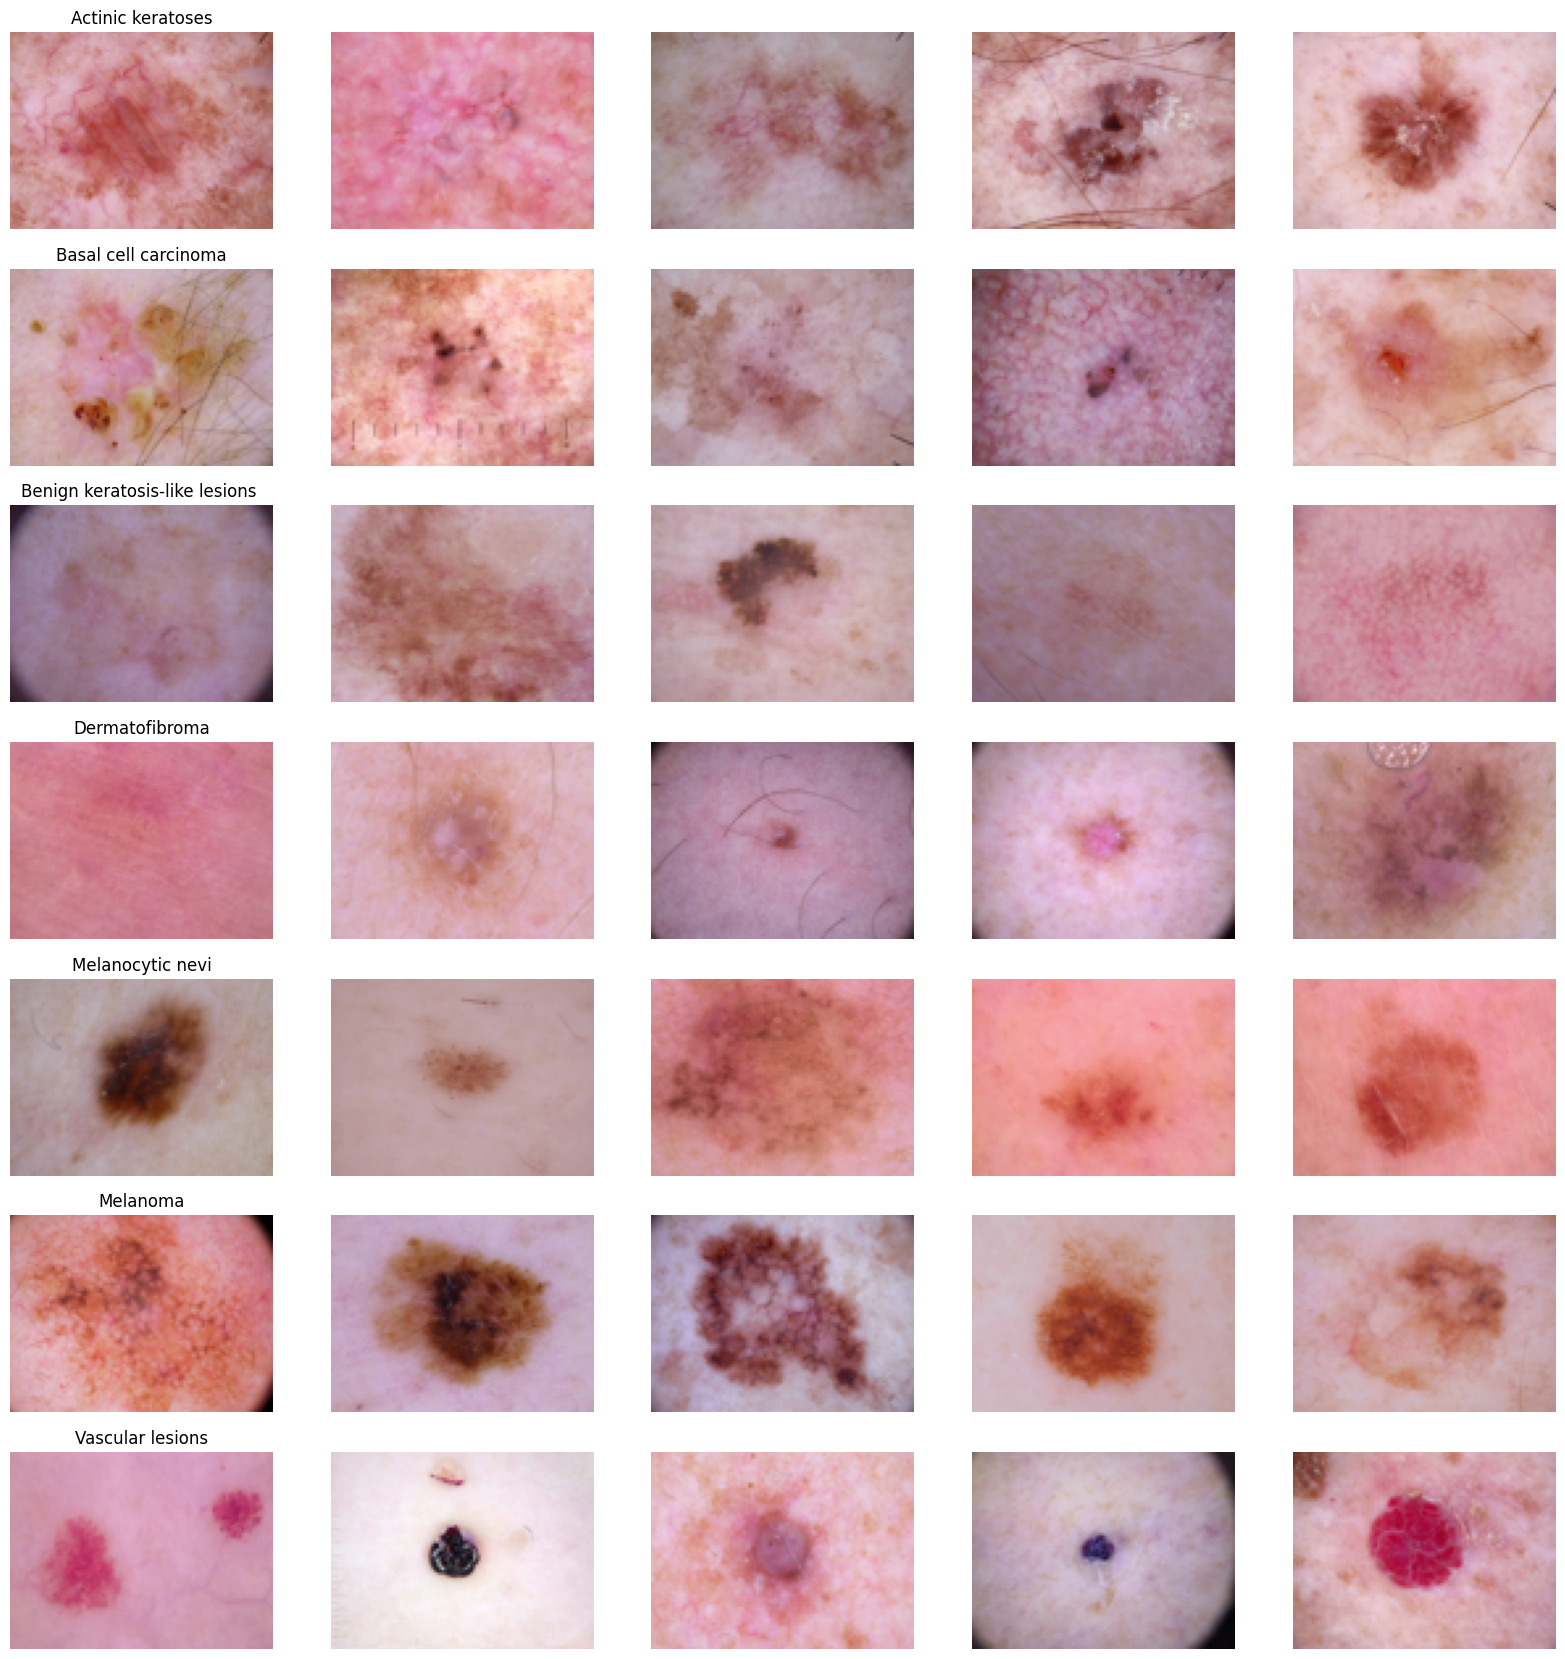

In [24]:
n_samples = 5
fig, axs = plt.subplots(7, n_samples, figsize=(4*n_samples, 3*7))

for n_axs, (type_name, type_rows) in zip(axs,
                                         skin_df.sort_values(['cell_type']).groupby('cell_type')):
    n_axs[0].set_title(type_name)
    for c_ax, (_, c_row) in zip(n_axs, type_rows.sample(n_samples, random_state=1234).iterrows()):
        c_ax.imshow(c_row['image'])
        c_ax.axis('off')
fig.savefig('category_samples.png', dpi=300)


In [25]:
skin_df.image.map(lambda x: x.shape).value_counts()

image
(75, 100, 3)    4710
Name: count, dtype: int64

In [26]:
features=skin_df.drop(columns=['cell_type_idx'],axis=1)
target=skin_df['cell_type_idx']

# Train Test Split

In [27]:
x_train_o, x_test_o, y_train_o, y_test_o = train_test_split(features, target, test_size=0.20,random_state=1234)

In [28]:
x_train_o.shape, x_test_o.shape

((3768, 10), (942, 10))

# Normalize

In [29]:
x_train = np.asarray(x_train_o['image'].tolist())
x_test = np.asarray(x_test_o['image'].tolist())

x_train_mean = np.mean(x_train)
x_train_std = np.std(x_train)

x_test_mean = np.mean(x_test)
x_test_std = np.std(x_test)

x_train = (x_train - x_train_mean)/x_train_std
x_test = (x_test - x_test_mean)/x_test_std

In [30]:
# Perform one-hot encoding on the labels
y_train = keras.utils.to_categorical(y_train_o, num_classes = 7)
y_test = keras.utils.to_categorical(y_test_o, num_classes = 7)

Splitting training and validation set

In [31]:
x_train, x_validate, y_train, y_validate = train_test_split(x_train, y_train, test_size = 0.1, random_state = 2)

In [32]:
x_train.shape, x_validate.shape

((3391, 75, 100, 3), (377, 75, 100, 3))

In [33]:
# Reshape image in 3 dimensions (height = 75px, width = 100px , canal = 3)
x_train = x_train.reshape(x_train.shape[0], *(75, 100, 3))
x_test = x_test.reshape(x_test.shape[0], *(75, 100, 3))
x_validate = x_validate.reshape(x_validate.shape[0], *(75, 100, 3))

In [34]:
x_train.shape, x_validate.shape

((3391, 75, 100, 3), (377, 75, 100, 3))

# Model building

In [51]:
input_shape = (75, 100, 3)
num_classes = 7


model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3),activation='relu',padding = 'Same',input_shape=input_shape))
model.add(layers.Conv2D(32,(3, 3), activation='relu',padding = 'Same',))
model.add(layers.MaxPool2D(pool_size = (2, 2)))
model.add(layers.BatchNormalization())

model.add(layers.Conv2D(64, (3, 3), activation='relu',padding = 'Same'))
model.add(layers.Conv2D(64, (3, 3), activation='relu',padding = 'Same'))
model.add(layers.MaxPool2D(pool_size=(2, 2)))
model.add(layers.BatchNormalization())

model.add(layers.Conv2D(128, (3, 3), activation='relu',padding = 'Same'))
model.add(layers.Conv2D(128, (3, 3), activation='relu',padding = 'Same'))
model.add(layers.MaxPool2D(pool_size=(2, 2)))
model.add(layers.BatchNormalization())

model.add(layers.Conv2D(256, (3, 3), activation='relu',padding = 'Same'))
model.add(layers.Conv2D(256, (3, 3), activation='relu',padding = 'Same'))
model.add(layers.MaxPool2D(pool_size=(2, 2)))
model.add(layers.BatchNormalization())

model.add(layers.Flatten())
model.add(layers.Dropout(0.2))
model.add(layers.Dense(128, activation='relu'))
model.add(layers.BatchNormalization())
model.add(layers.Dense(64, activation='relu'))
model.add(layers.BatchNormalization())
model.add(layers.Dense(32, activation='relu'))
model.add(layers.BatchNormalization())


model.add(layers.Dense(num_classes, activation='softmax'))
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_16 (Conv2D)          (None, 75, 100, 32)       896       
                                                                 
 conv2d_17 (Conv2D)          (None, 75, 100, 32)       9248      
                                                                 
 max_pooling2d_7 (MaxPoolin  (None, 37, 50, 32)        0         
 g2D)                                                            
                                                                 
 batch_normalization_3 (Bat  (None, 37, 50, 32)        128       
 chNormalization)                                                
                                                                 
 conv2d_18 (Conv2D)          (None, 37, 50, 64)        18496     
                                                                 
 conv2d_19 (Conv2D)          (None, 37, 50, 64)       

In [52]:
# Compile the model
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [53]:
# Set a learning rate annealer
learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy'
                                            , patience = 2
                                            , verbose=1
                                            ,factor=0.5
                                            , min_lr=0.00001)

# Data Augmentation

In [54]:
# With data augmentation to prevent overfitting

datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range=10,  # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.1, # Randomly zoom image
        width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
        horizontal_flip=False,  # randomly flip images
        vertical_flip=False)  # randomly flip images

datagen.fit(x_train)

# Fitting the Model

In [55]:
# Fit the model
epochs = 25
batch_size = 128
history = model.fit_generator(datagen.flow(x_train,y_train, batch_size=batch_size),
                              epochs = epochs, validation_data = (x_validate,y_validate),
                              verbose = 1, steps_per_epoch=x_train.shape[0] // batch_size
                              , callbacks=[learning_rate_reduction])

<ipython-input-55-b4c29c26e3b0>:4: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(datagen.flow(x_train,y_train, batch_size=batch_size),


Epoch 1/25
26/26 [==============================] - 19s 421ms/step - loss: 1.6223 - accuracy: 0.4465 - val_loss: 1.9501 - val_accuracy: 0.3236 - lr: 0.0010
Epoch 2/25
26/26 [==============================] - 7s 247ms/step - loss: 1.3240 - accuracy: 0.5250 - val_loss: 2.1205 - val_accuracy: 0.3448 - lr: 0.0010
Epoch 3/25
26/26 [==============================] - 9s 363ms/step - loss: 1.2157 - accuracy: 0.5587 - val_loss: 1.9617 - val_accuracy: 0.3979 - lr: 0.0010
Epoch 4/25
26/26 [==============================] - 9s 337ms/step - loss: 1.1186 - accuracy: 0.5814 - val_loss: 1.8310 - val_accuracy: 0.4111 - lr: 0.0010
Epoch 5/25
26/26 [==============================] - 8s 297ms/step - loss: 1.0642 - accuracy: 0.6080 - val_loss: 1.6048 - val_accuracy: 0.4430 - lr: 0.0010
Epoch 6/25
26/26 [==============================] - 9s 338ms/step - loss: 1.0352 - accuracy: 0.6203 - val_loss: 1.5561 - val_accuracy: 0.3767 - lr: 0.0010
Epoch 7/25
26/26 [==============================] - ETA: 0s - loss: 0

# Model Evaluation

In [56]:
loss, accuracy = model.evaluate(x_test, y_test, verbose=1)
loss_v, accuracy_v = model.evaluate(x_validate, y_validate, verbose=1)
print("Validation: accuracy = %f  ;  loss_v = %f" % (accuracy_v, loss_v))
print("Test: accuracy = %f  ;  loss = %f" % (accuracy, loss))

12/12 [==============================] - 0s 9ms/step - loss: 1.0541 - accuracy: 0.6684
Validation: accuracy = 0.668435  ;  loss_v = 1.054080
Test: accuracy = 0.629512  ;  loss = 1.082897
